In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import imblearn

from matplotlib import pyplot
import matplotlib.pyplot as plt

### Utility functions

In [3]:
def load_dataset(filename, feature_columns):
    data = pd.read_csv(filename)
    
     # maybe we need more columns 
    prediction_columns = ['impact']
    
    X = data[feature_columns].values
    y = data[prediction_columns].values
    
    X = X.astype(str)
    y = y.astype(str)
    return X, y

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

def select_features(X_train, y_train, X_test, k):
    fs = SelectKBest(score_func=chi2, k=k)
    # fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def compute_class_accuracy(y_test_enc, yhat):
    matrix = confusion_matrix(y_test_enc, yhat)
    print(matrix.diagonal()/matrix.sum(axis=1))

### Dataset
Split data into training and testing part. 
Due to the imbalance of classes (over 90% of the dataset belongs to one class) we will adjust by undersampling the training set.

In [38]:
df = pd.read_csv('data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()


,ID,ID_status,active,count_reassign,count_opening,count_updated,ID_caller,opened_by,opened_time,Created_by,...,category_ID,user_symptom,Support_group,support_incharge,Doc_knowledge,confirmation_check,impact,notify,problem_ID,change_request
0,INC0000045,New,True,0,0,0,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
1,INC0000045,Resolved,True,0,0,3,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
2,INC0000045,Closed,False,0,0,4,Caller 2403,Opened by 8,29-02-2016 01:16,Created by 6,...,Category 55,Symptom 72,Group 56,?,True,False,2 - Medium,Do Not Notify,?,?
3,INC0000047,Active,True,1,0,1,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,...,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?
4,INC0000047,Active,True,1,0,2,Caller 2403,Opened by 397,29-02-2016 04:40,Created by 171,...,Category 40,Symptom 471,Group 24,Resolver 31,True,False,2 - Medium,Do Not Notify,?,?


In [62]:
feature_columns = [
        'location',
        'count_reassign',
        'count_opening',
        'count_updated',
        'category_ID',
        'opened_time',
        'user_symptom',
        'updated_at'
    ]
X, y = load_dataset('data.csv', feature_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)
# Summary of train and test
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

print(f" {np.unique(y_train, return_counts=True)[1]}")

## Resampling
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(f" {np.unique(y_train, return_counts=True)[1]}")

Train (59518, 8) (59518, 1)
Test (39680, 8) (39680, 1)
 [ 1480 56414  1624]
 [1480 1480 1480]


### Processing
We process and encode the features

In [63]:
# Prepare features and select 2 best
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train.ravel(), y_test.ravel())

X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc, k=2)

### Feature evaluation
Perform chi-squared test for feature relevance.
We can observe that there are two features that stand out w.r.t. to the others, and we'll use those to train the model.

Feature 0 location: 104.2799193054841
Feature 1 count_reassign: 208.98965338851713
Feature 2 count_opening: 3.7142857142857477
Feature 3 count_updated: 2060.351754423202
Feature 4 category_ID: 15.413571460344428
Feature 5 opened_time: 27142.63013744786
Feature 6 user_symptom: 2518.8940754283767
Feature 7 updated_at: 14462.614459423225


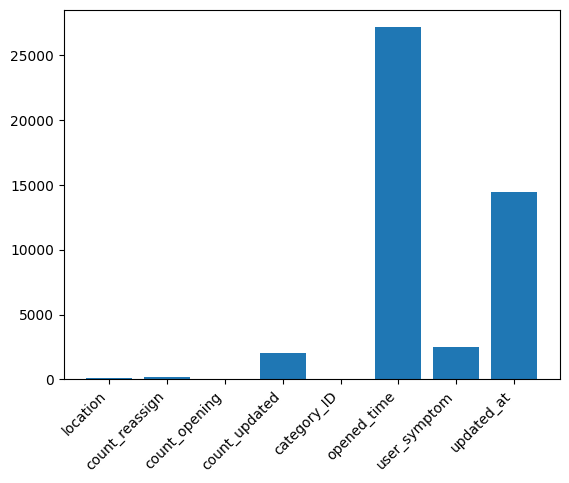

In [69]:
for i in range(len(fs.scores_)):
    print(f'Feature {i} {feature_columns[i]}: {fs.scores_[i]}')

ax1 = plt.subplot()
ax1.set_xticks(range(len(feature_columns)))
ax1.set_xticklabels(feature_columns, rotation = 45, ha="right")

# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.savefig('feature_relevance_chi_squared.png', bbox_inches="tight")

### Model training
We opt for GradientBoostedTrees as the model.

In [8]:
# Gradient Boosted Trees
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=20, random_state=0).fit(X_train_enc, y_train_enc)
print(clf.score(X_test_enc, y_test_enc))

yhat = clf.predict(X_test_enc)
compute_class_accuracy(y_test_enc, yhat)

0.8752016129032258
[0.80809129 0.88274854 0.67518248]


### Metrics
To evaluate we compute the confusion matrix, class accuracies and F1 score.

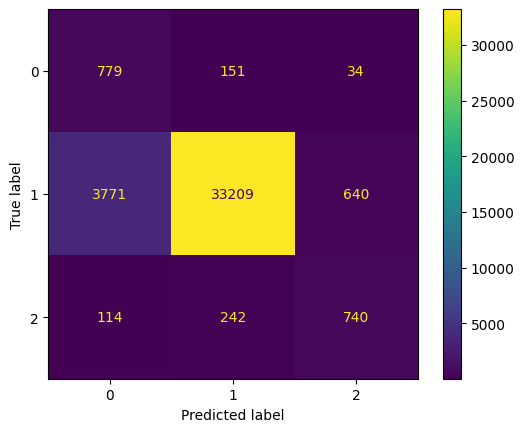

In [9]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_enc, yhat, labels=np.unique(y_test_enc))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_enc))
disp.plot() 

In [22]:
score = f1_score(y_test_enc, yhat, average='weighted')
print(f'weighted: {score:.2f}')

macro: 0.60
micro: 0.88
weighted: 0.91


### Conclusion

The goal is to detect incidents of high impact, such that they can be solved as soon as possible.
The model correctly predicts the incidents with high accuracy over 80% of the time. While there are some false positives, the assumption is 
that it can be more costly to neglect the incidents of high importance, rather than detecting slightly more of them.